<a href="https://colab.research.google.com/github/vivekd16/Deep-Learning/blob/main/02_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#neural network classification

In [2]:
from sklearn.datasets import make_circles

n_samples=1000
X,y=make_circles(n_samples,noise=0.03,random_state=42)

In [3]:
len(X),len(y)

(1000, 1000)

In [4]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [5]:
import pandas as pd
circles=pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


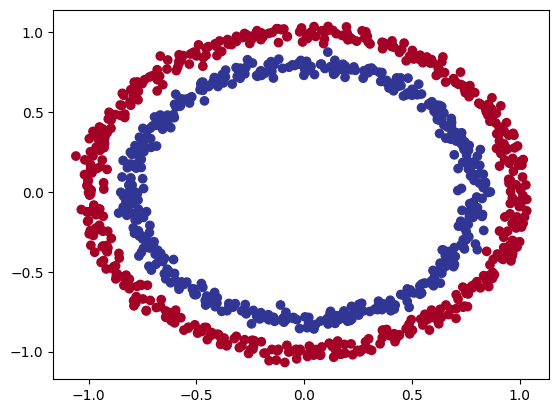

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,
            cmap=plt.cm.RdYlBu)

In [7]:
X.shape,y.shape

((1000, 2), (1000,))

In [8]:
X[0],y[0]

(array([0.75424625, 0.23148074]), 1)

In [9]:
import torch

In [10]:
type(X)

numpy.ndarray

In [11]:
X=torch.from_numpy(X).type(torch.float)

In [12]:
y=torch.from_numpy(y).type(torch.float)

In [13]:
type(X),X.dtype,y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
len(X_train),len(X_test)

(800, 200)

In [17]:
import torch
from torch import nn
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
class circlemodelv0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=5)
    self.layer_2=nn.Linear(in_features=5,out_features=1)
  def forward(self,x):
    return self.layer_2(self.layer_1(x))
model_0=circlemodelv0().to(device)
model_0

circlemodelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0=nn.Sequential(nn.Linear(in_features=2,out_features=5,bias=True),nn.Linear(in_features=5,out_features=1,bias=True)).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6264, -0.5851],
                      [ 0.5389, -0.6142],
                      [-0.4067, -0.0109],
                      [ 0.3264,  0.6558],
                      [-0.6871, -0.2371]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.5101,  0.5366, -0.1808,  0.2791, -0.4553], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0238, -0.2816,  0.2650, -0.0317,  0.4103]], device='cuda:0')),
             ('1.bias', tensor([0.3024], device='cuda:0'))])

In [21]:
with torch.inference_mode():
  untrained_preds=model_0(X_test.to(device))
[len(untrained_preds),untrained_preds.shape,len(X_test),X_test.shape,untrained_preds[:10],y_test[:10]]

[200,
 torch.Size([200, 1]),
 200,
 torch.Size([200, 2]),
 tensor([[ 0.1473],
         [-0.0518],
         [ 0.2852],
         [ 0.1099],
         [-0.3245],
         [-0.4413],
         [-0.5188],
         [-0.6115],
         [ 0.3107],
         [-0.0719]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])]

In [22]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [23]:
def accuracy_fn(y_true,y_preds):
  correct=torch.eq(y_true,y_preds).sum().item()
  acc=(correct/len(y_preds))*100
  return acc

In [24]:
device

'cuda'

In [25]:
!nvidia-smi

Fri Feb 28 15:29:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P0             28W /   70W |     150MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
#training loop

In [27]:
torch.cuda.manual_seed=42
epochs=1000
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_0.train()
  y_logits=model_0(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_preds=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_0.eval()
  with torch.inference_mode():
    test_logits=model_0(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_preds=test_preds)
  if epoch%10==0:
    print(f"epoch:{epoch} | loss:{loss:.5f},acc:{acc:.2f}| test_loss:{test_loss:.5f},test_acc:{test_acc:.2f}")

epoch:0 | loss:0.70978,acc:49.50| test_loss:0.70256,test_acc:48.50
epoch:10 | loss:0.70394,acc:50.38| test_loss:0.69821,test_acc:49.50
epoch:20 | loss:0.70125,acc:50.38| test_loss:0.69639,test_acc:50.00
epoch:30 | loss:0.69966,acc:50.88| test_loss:0.69543,test_acc:50.50
epoch:40 | loss:0.69853,acc:50.62| test_loss:0.69481,test_acc:50.50
epoch:50 | loss:0.69765,acc:51.00| test_loss:0.69436,test_acc:50.50
epoch:60 | loss:0.69694,acc:50.75| test_loss:0.69404,test_acc:50.50
epoch:70 | loss:0.69635,acc:50.38| test_loss:0.69379,test_acc:50.50
epoch:80 | loss:0.69585,acc:50.38| test_loss:0.69361,test_acc:52.00
epoch:90 | loss:0.69543,acc:50.62| test_loss:0.69348,test_acc:52.00
epoch:100 | loss:0.69508,acc:50.50| test_loss:0.69339,test_acc:52.50
epoch:110 | loss:0.69478,acc:50.50| test_loss:0.69333,test_acc:54.00
epoch:120 | loss:0.69453,acc:50.12| test_loss:0.69330,test_acc:53.50
epoch:130 | loss:0.69431,acc:50.50| test_loss:0.69329,test_acc:54.00
epoch:140 | loss:0.69412,acc:49.88| test_loss

In [28]:
from urllib import request
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("downloading helper_functions.py")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
  from helper_functions import plot_predictions,plot_decision_boundary

downloading helper_functions.py


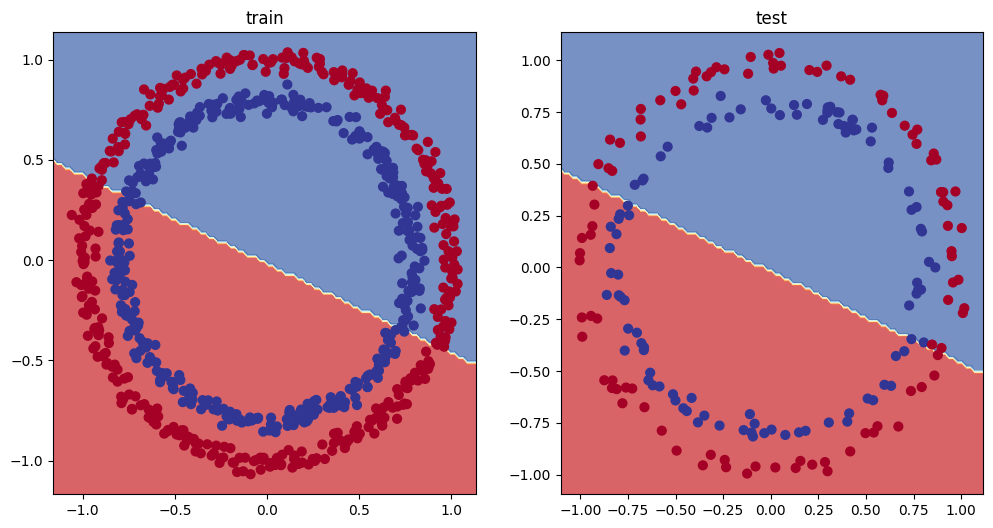

In [29]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0,X_test,y_test)

In [30]:
class circlemodelv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2,out_features=10)
        self.layer_2=nn.Linear(in_features=10,out_features=10)
        self.layer_3=nn.Linear(in_features=10,out_features=1)
    def forward(self,x):
        z=self.layer_1(x)
        z=self.layer_2(z)
        z=self.layer_3(z)
        return z
model_1=circlemodelv1().to(device)
model_1


circlemodelv1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),lr=0.01)

In [32]:
torch.manual_seed(42)
epochs=1000
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_logits=model_1(X_train).squeeze()
    y_preds=torch.round(torch.sigmoid(y_logits))
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,y_preds=y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_1.eval()
    with torch.inference_mode():
        test_logits=model_1(X_test).squeeze()
        test_preds=torch.round(torch.sigmoid(test_logits))
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,y_preds=test_preds)
    if epoch%100==0:
        print(f"epoch:{epoch} | loss:{loss:.5f},acc:{acc:.2f}| test_loss:{test_loss:.5f},test_acc:{test_acc:.2f}")

epoch:0 | loss:0.69578,acc:50.12| test_loss:0.69380,test_acc:48.50
epoch:100 | loss:0.69298,acc:51.00| test_loss:0.69467,test_acc:45.50
epoch:200 | loss:0.69298,acc:51.00| test_loss:0.69468,test_acc:46.00
epoch:300 | loss:0.69298,acc:51.00| test_loss:0.69468,test_acc:46.00
epoch:400 | loss:0.69298,acc:51.00| test_loss:0.69468,test_acc:46.00
epoch:500 | loss:0.69298,acc:51.00| test_loss:0.69468,test_acc:46.00
epoch:600 | loss:0.69298,acc:51.00| test_loss:0.69468,test_acc:46.00
epoch:700 | loss:0.69298,acc:51.00| test_loss:0.69468,test_acc:46.00
epoch:800 | loss:0.69298,acc:51.00| test_loss:0.69468,test_acc:46.00
epoch:900 | loss:0.69298,acc:51.00| test_loss:0.69468,test_acc:46.00


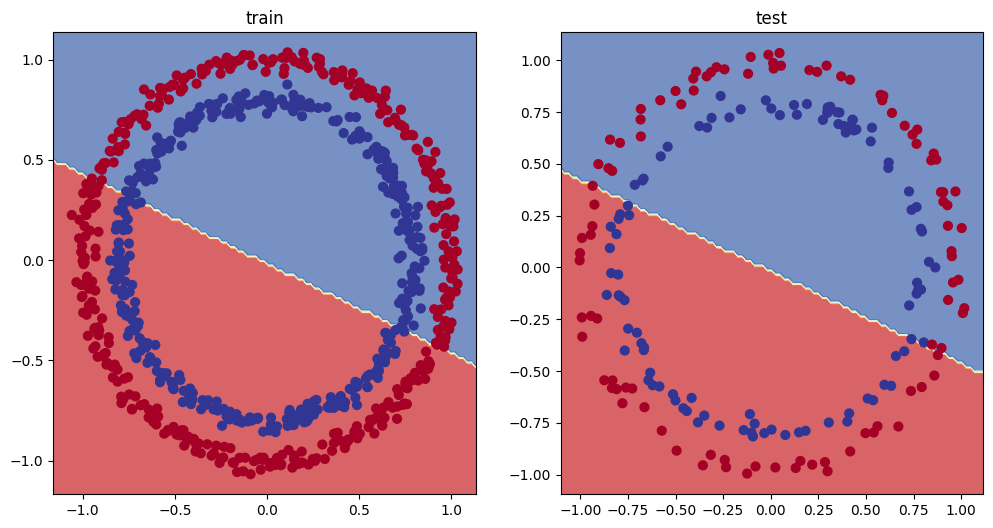

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0,X_test,y_test)

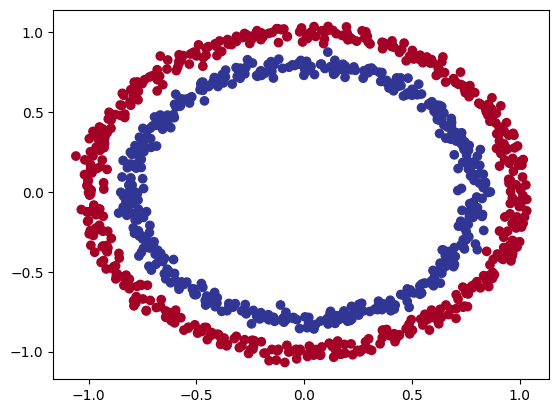

In [34]:
from sklearn.datasets import make_circles

n_samples=1000
X,y=make_circles(n_samples,noise=0.03,random_state=42)

import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,
            cmap=plt.cm.RdYlBu)

In [35]:
import torch
from sklearn.model_selection import train_test_split
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [36]:
#non-linear

In [37]:
from torch import nn
class circlemodelv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2,out_features=10)
        self.layer_2=nn.Linear(in_features=10,out_features=10)
        self.layer_3=nn.Linear(in_features=10,out_features=1)
        self.relu=nn.ReLU()
    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3=circlemodelv2().to(device)
model_3

circlemodelv2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [38]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_3.parameters(),lr=0.1)

In [39]:
torch.manual_seed(42)
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

epochs=3000
for epoch in range(epochs):
    model_3.train()
    y_logits=model_3(X_train.to(device)).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,y_preds=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_3.eval()
    with torch.inference_mode():
        test_logits=model_3(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,y_preds=test_pred)
    if epoch%100==0:
        print(f"epoch:{epoch} | loss:{loss:.5f},acc:{acc:.2f}| test_loss:{test_loss:.5f},test_acc:{test_acc:.2f}")

epoch:0 | loss:0.69295,acc:50.00| test_loss:0.69319,test_acc:50.00
epoch:100 | loss:0.69115,acc:52.88| test_loss:0.69102,test_acc:52.50
epoch:200 | loss:0.68977,acc:53.37| test_loss:0.68940,test_acc:55.00
epoch:300 | loss:0.68795,acc:53.00| test_loss:0.68723,test_acc:56.00
epoch:400 | loss:0.68517,acc:52.75| test_loss:0.68411,test_acc:56.50
epoch:500 | loss:0.68102,acc:52.75| test_loss:0.67941,test_acc:56.50
epoch:600 | loss:0.67515,acc:54.50| test_loss:0.67285,test_acc:56.00
epoch:700 | loss:0.66659,acc:58.38| test_loss:0.66322,test_acc:59.00
epoch:800 | loss:0.65160,acc:64.00| test_loss:0.64757,test_acc:67.50
epoch:900 | loss:0.62362,acc:74.00| test_loss:0.62145,test_acc:79.00
epoch:1000 | loss:0.56818,acc:87.75| test_loss:0.57378,test_acc:86.50
epoch:1100 | loss:0.48153,acc:93.50| test_loss:0.49935,test_acc:90.50
epoch:1200 | loss:0.37056,acc:97.75| test_loss:0.40595,test_acc:92.00
epoch:1300 | loss:0.25458,acc:99.00| test_loss:0.30333,test_acc:96.50
epoch:1400 | loss:0.17180,acc:99

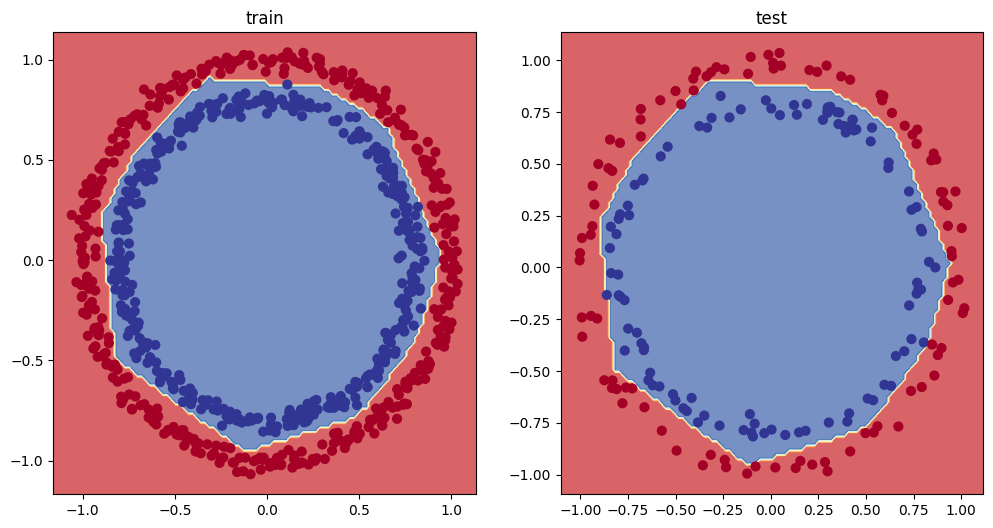

In [40]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_3,X_test,y_test)

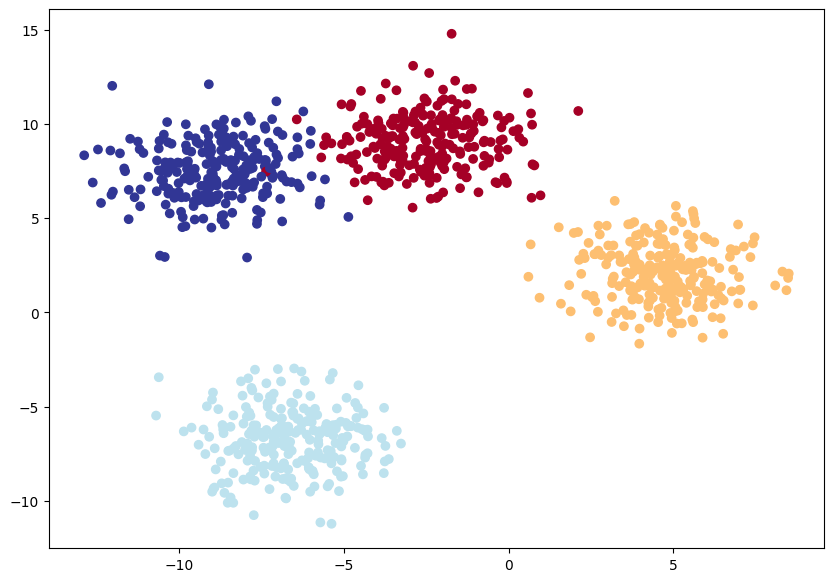

In [41]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

X_blob,y_blob=make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES,cluster_std=1.5,random_state=RANDOM_SEED)

X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)


In [42]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [43]:
class blobmodel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,x):
    return self.linear_layer_stack(x)

model_4=blobmodel(input_features=2,output_features=4,hidden_units=8).to(device)
model_4

blobmodel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [44]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model_4.parameters(),lr=0.1)

In [45]:
model_4.eval()
with torch.inference_mode():
  y_Logits=model_4(X_blob_test.to(device))
y_Logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [46]:
y_preds_prob=torch.softmax(y_Logits,dim=1)
y_preds_prob[:10]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463],
        [0.3381, 0.1358, 0.1929, 0.3331],
        [0.2867, 0.1841, 0.2861, 0.2431],
        [0.3554, 0.1355, 0.1740, 0.3351],
        [0.3009, 0.1841, 0.2779, 0.2371],
        [0.3595, 0.1350, 0.1695, 0.3360]], device='cuda:0')

In [47]:
torch.argmax(y_preds_prob[0])

tensor(1, device='cuda:0')

In [48]:
y_preds=torch.argmax(y_preds_prob,dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [49]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [50]:
#training and testing loop

In [51]:
torch.manual_seed(42)
epochs=100
X_blob_train,y_blob_train,X_blob_test,y_blob_test=X_blob_train.to(device),y_blob_train.to(device),X_blob_test.to(device),y_blob_test.to(device)
for epoch in range(epochs):
  model_4.train()
  y_logits=model_4(X_blob_train)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss=loss_fn(y_logits,y_blob_train)
  acc=accuracy_fn(y_true=y_blob_train,y_preds=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_4.eval()
  with torch.inference_mode():
    test_logits=model_4(X_blob_test)
    test_preds=torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc=accuracy_fn(y_true=y_blob_test,y_preds=test_preds)
  if epoch%10==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%
